# Neuro Science Project one 

## Pre Processing 

### Import libraries

In [2126]:
from pymonntorch import Network, NeuronGroup, Recorder, EventRecorder, SynapseGroup
import torch
from matplotlib import pyplot as plt
import math
import random

### Time Resolution

In [2127]:
class TR(Behavior):
    def initialize(self, network):
        network.dt = self.parameter("dt", 1.0)

### Current 

In [2128]:
class SetCurrent(Behavior):
    def initialize(self, ng):
        self.offset = self.parameter("value")
        ng.I = ng.vector(mode=self.offset)

    def forward(self, ng):
        ng.I.fill_(self.offset)

#### Current: Step Function

In [2129]:
class StepFunction(Behavior):
    def initialize(self, ng):
        self.value = self.parameter("value")
        self.t0 = self.parameter("t0")
        
    def forward(self, ng):
        if ng.network.iteration * ng.network.dt >= self.t0:
            ng.I += ng.vector(mode = self.value) * ng.network.dt

#### Current: Sin Function

In [2130]:
class SinFunction(Behavior):
    def initialize(self,ng):
        self.value = self.parameter("value")
        self.a = self.parameter("a")
    
    def forward(self, ng):
        for i in range (int(ng.network.iteration * ng.network.dt)):
            ng.I = ng.vector(mode = self.a*math.sin(i*ng.network.iteration/(3*math.pi)) + self.value)

#### Current: Static with noise

In [2131]:
class NoiseFunction(Behavior):
    def initialize(self,ng):
        self. value = self.parameter("value")
        ng.I = ng.vector(mode = self.value)
        self.limit = self.parameter("limit")
        self.rate = self.parameter("rate")
    
    def forward(self, ng):
        if(random.random() < self.rate):
            ng.I = ng.vector(mode = self.value + self.limit*(2*random.random()-1))
        else:
            ng.I = ng.vector(mode = self.value)

### Synapse

In [2132]:
class SynapseFunction(Behavior):
    def initialize(self, sg):
        sg.w = sg.matrix(mode = "normal(0.5, 0.3)")
        sg.I = sg.dst.vector()

    def forward(self, sg):
        sg.I = torch.sum(sg.w[sg.src.spike], axis=0)



#### Dendrit

In [ ]:
class InputSynapse(Behavior):
    def forward(self, ng):
        for syn in ng.afferent_synapses["All"]:
            ng.I += syn.I

## LIF Model

In [2194]:
class LIF(Behavior):
    def initialize(self, ng):
        k = self.parameter("v_init" , default = "normal(0.3,0.05)")
        self.tau  = self.parameter("tau")
        self.u_rest = self.parameter("u_rest")
        self.u_reset = self.parameter("u_reset")
        self.threshold = self.parameter("threshold")
        self.R = self.parameter("R")

        ng.v = ng.vector(mode = k)
        ng.spike = ng.v >= self.threshold 
        ng.v[ng.spike] = self.u_reset

    def forward(self, ng):
        #dynamic
        leakage = -(ng.v-self.u_rest)
        currents = self.R *ng.I 
        ng.v += (leakage + currents) / self.tau * ng.network.dt
        
        #firing 
        ng.spike = ng.v >= self.threshold

        #reset 
        ng.v[ng.spike] = self.u_reset

### LIF with refactory period

In [ ]:
class LIF(Behavior):
    def initialize(self, ng):
        k = self.parameter("v_init" , default = "normal(0.3,0.05)")
        self.tau  = self.parameter("tau")
        self.u_rest = self.parameter("u_rest")
        self.u_reset = self.parameter("u_reset")
        self.threshold = self.parameter("threshold")
        self.R = self.parameter("R")
        self.rp = self.parameter("refractory_period")

        ng.v = ng.vector(mode = k)
        ng.rp = ng.vector(mode = 0)
        ng.spike = ng.v >= self.threshold 
        ng.rp[ng.spike] = self.rp
        ng.v[ng.spike] = self.u_reset

    def forward(self, ng):
        #dynamic
        leakage = -(ng.v-self.u_rest)
        currents = self.R *ng.I 
        ng.v += (leakage + currents) / self.tau * ng.network.dt
        ng.v[ng.rp > 0] = self.u_reset
        ng.rp -= 1

        #firing 
        ng.spike = ng.v >= self.threshold

        #reset 
        ng.rp[ng.spike] = self.rp
        ng.v[ng.spike] = self.u_reset

### With constant function:

In [2195]:
net = Network(behavior={1: TR()}, dtype = torch.float64)

In [2196]:
ng1 = NeuronGroup(
    100,
    net = net, 
    behavior={
        2: SetCurrent(value=55),
        #3: StepFunction(value=20, t0=40),
        #4: InputSynapse(),
        5: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-73.42,
            threshold=-13,
            R=1,
            refractory_period = 3,
            v_init="normal(-40, 10)",),
            
            9: Recorder(variables=["v", "I"], tag="ng1_rec, ng1_recorder"),
            10: EventRecorder("spike", tag="ng1_evrec"),
    },
    tag="NG1",
)

In [2197]:
SynapseGroup(net=net, src=ng1, dst=ng1, behavior={
                 3: SynapseFunction(),
             })


SynapseGroup['SynapseGroup_1', 'SynapseGroup', 'syn', 'NG1 => NG1'](S100xD100){3:SynapseFunction(),}

Network['Network_1', 'Network'](Neurons: tensor(100)|1 groups, Synapses: tensor(10000)|1 groups){1:TR()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](100){2:SetCurrent(value=55,)5:LIF(tau=10,u_rest=-65,u_reset=-73.42,threshold=-13,R=1,refractory_period=3,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_evrec,arg_0=spike,)}
SynapseGroup['SynapseGroup_1', 'SynapseGroup', 'syn', 'NG1 => NG1'](S100xD100){3:SynapseFunction(),}
100xBatch: 1/1 (100%) 177.309ms


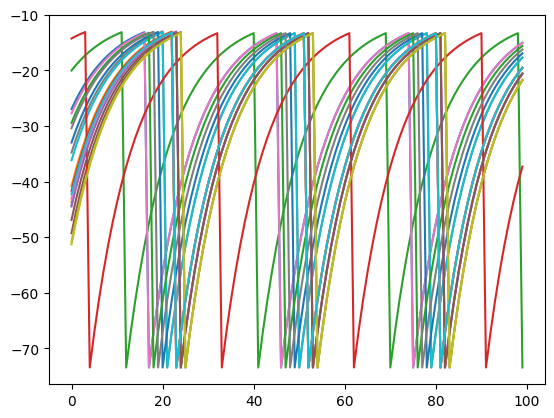

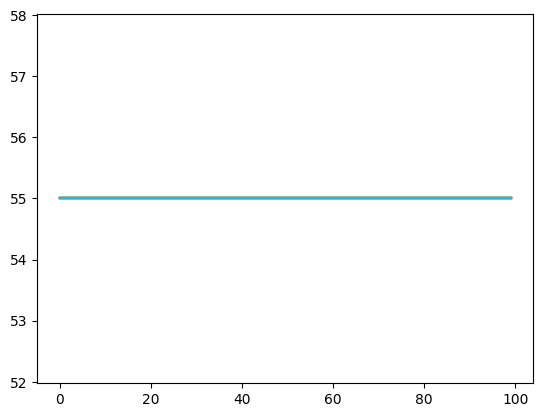

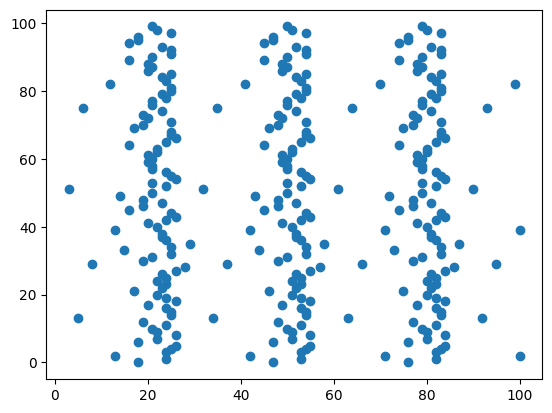

In [2198]:
net.initialize()
net.simulate_iterations(100)

plt.plot(net["v", 0][:,:20])
plt.show()
plt.plot(net["I", 0][:,:20])
plt.show()

plt.scatter(net["spike", 0][:,0], net["spike", 0][:,1])
plt.show()


In [2138]:
print(net["I",0])

tensor([[55., 55., 55.,  ..., 55., 55., 55.],
        [55., 55., 55.,  ..., 55., 55., 55.],
        [55., 55., 55.,  ..., 55., 55., 55.],
        ...,
        [55., 55., 55.,  ..., 55., 55., 55.],
        [55., 55., 55.,  ..., 55., 55., 55.],
        [55., 55., 55.,  ..., 55., 55., 55.]], dtype=torch.float64)


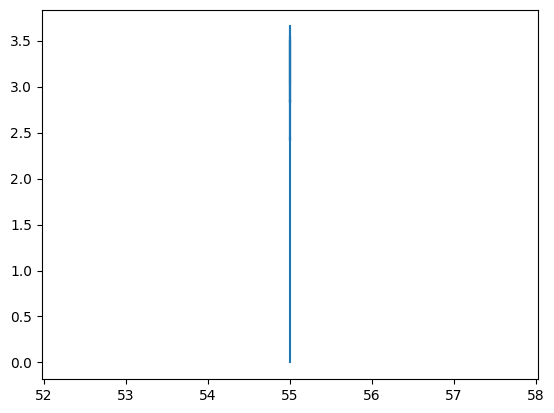

In [2139]:
spike_x = []
spike_y = []
num_spike = 0
dt = 1
iteration = 100
for i in range (1,iteration):
    num_spike +=  int(sum(net["spike"][0] == i*dt)[0])
    spike_x.append(int(net["I",0][i,0]))
    spike_y.append(num_spike/(i*dt))

plt.plot(spike_x, spike_y)
plt.show()

### With step Function

In [2140]:
net = Network(behavior={1: TR()}, dtype = torch.float64)

In [2141]:
ng1 = NeuronGroup(
    100,
    net = net, 
    behavior={
        2: SetCurrent(value=55),
        3: StepFunction(value=20, t0=40),
        5: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-73.42,
            threshold=-13,
            R=1,
            v_init="normal(-40, 10)",),
            9: Recorder(variables=["v", "I"], tag="ng1_rec, ng1_recorder"),
            10: EventRecorder("spike", tag="ng1_evrec"),
    },
    tag="NG1",
)

Network['Network_1', 'Network'](Neurons: tensor(100)|1 groups, Synapses: tensor(0.)|0 groups){1:TR()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](100){2:SetCurrent(value=55,)3:StepFunction(value=20,t0=40,)5:LIF(tau=10,u_rest=-65,u_reset=-73.42,threshold=-13,R=1,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_evrec,arg_0=spike,)}
100xBatch: 1/1 (100%) 90.665ms


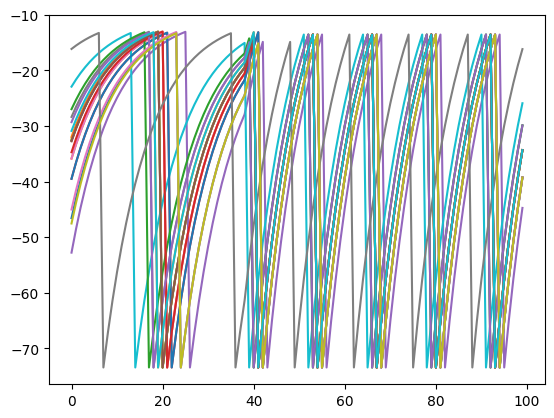

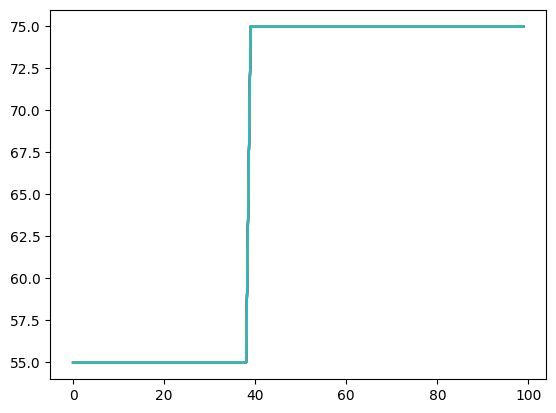

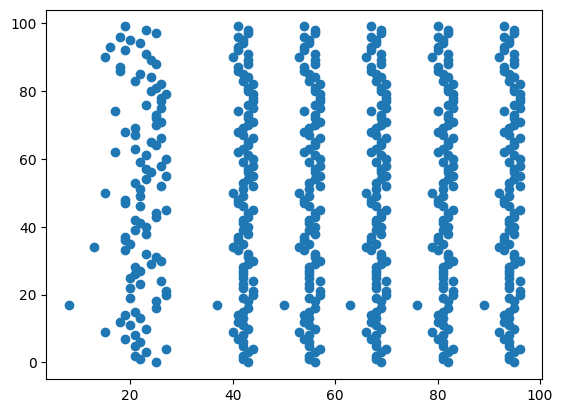

In [2142]:
net.initialize()
net.simulate_iterations(100)

plt.plot(net["v", 0][:,:20])
plt.show()
plt.plot(net["I", 0][:,:20])
plt.show()

plt.scatter(net["spike", 0][:,0], net["spike", 0][:,1])
plt.show()

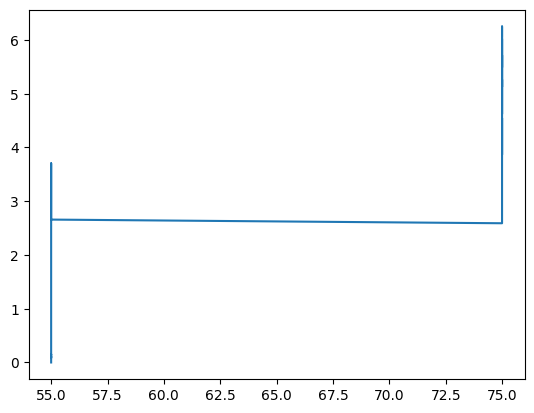

In [2143]:
spike_x = []
spike_y = []
num_spike = 0
dt = 1
iteration = 100
for i in range (1,iteration):
    num_spike +=  int(sum(net["spike"][0] == i*dt)[0])
    spike_x.append(int(net["I",0][i,0]))
    spike_y.append(num_spike/(i*dt))

plt.plot(spike_x, spike_y)
plt.show()

### With Sin Function

In [2144]:
net = Network(behavior={1: TR()}, dtype = torch.float64)

In [2145]:
ng1 = NeuronGroup(
    100,
    net = net, 
    behavior={
        2: SetCurrent(value=70),
        3: SinFunction(value=70, a=5),
        #4: InputSynapse(),
        5: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-73.42,
            threshold=-13,
            R=1,
            v_init="normal(-40, 10)",),
            9: Recorder(variables=["v", "I"], tag="ng1_rec, ng1_recorder"),
            10: EventRecorder("spike", tag="ng1_evrec"),
    },
    tag="NG1",
)

Network['Network_1', 'Network'](Neurons: tensor(100)|1 groups, Synapses: tensor(0.)|0 groups){1:TR()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](100){2:SetCurrent(value=70,)3:SinFunction(value=70,a=5,)5:LIF(tau=10,u_rest=-65,u_reset=-73.42,threshold=-13,R=1,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_evrec,arg_0=spike,)}


100xBatch: 1/1 (100%) 720.419ms


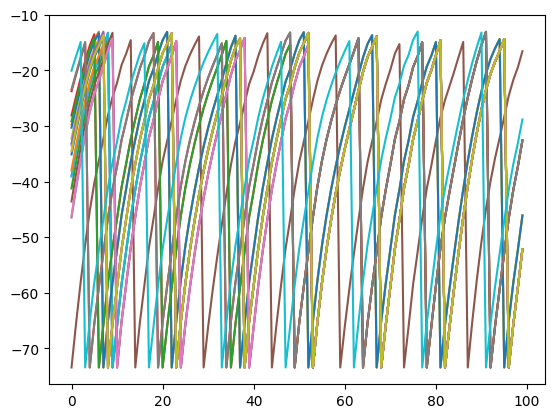

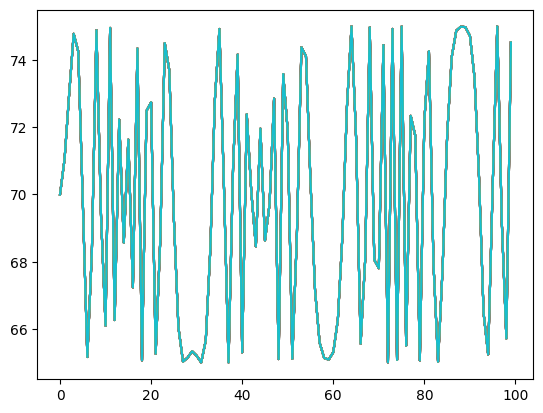

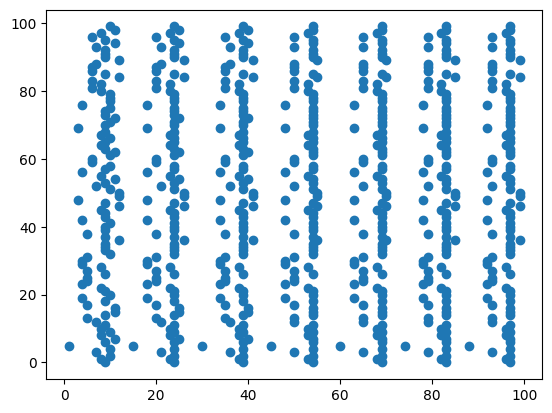

In [2146]:
net.initialize()
net.simulate_iterations(100)

plt.plot(net["v", 0][:,:20])
plt.show()
plt.plot(net["I", 0][:,:20])
plt.show()

plt.scatter(net["spike", 0][:,0], net["spike", 0][:,1])
plt.show()


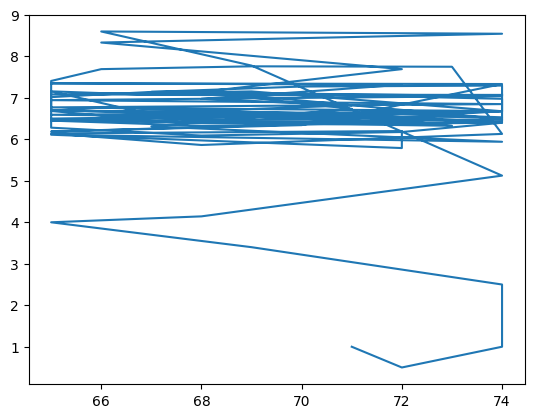

In [2147]:
spike_x = []
spike_y = []
num_spike = 0
dt = 1
iteration = 100
for i in range (1,iteration):
    num_spike +=  int(sum(net["spike"][0] == i*dt)[0])
    spike_x.append(int(net["I",0][i,0]))
    spike_y.append(num_spike/(i*dt))

plt.plot(spike_x, spike_y)
plt.show()

### With noisy Current

In [2148]:
net = Network(behavior={1: TR()}, dtype = torch.float64)

In [2149]:
ng1 = NeuronGroup(
    100,
    net = net, 
    behavior={
        2: SetCurrent(value=55),
        3: NoiseFunction(value=55,limit = 25, rate = 0.1),
        #4: InputSynapse(),
        5: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-73.42,
            threshold=-13,
            R=1,
            v_init="normal(-40, 10)",),
            9: Recorder(variables=["v", "I"], tag="ng1_rec, ng1_recorder"),
            10: EventRecorder("spike", tag="ng1_evrec"),
    },
    tag="NG1",
)

Network['Network_1', 'Network'](Neurons: tensor(100)|1 groups, Synapses: tensor(0.)|0 groups){1:TR()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](100){2:SetCurrent(value=55,)3:NoiseFunction(value=55,limit=25,rate=0.1,)5:LIF(tau=10,u_rest=-65,u_reset=-73.42,threshold=-13,R=1,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_evrec,arg_0=spike,)}


100xBatch: 1/1 (100%) 763.160ms


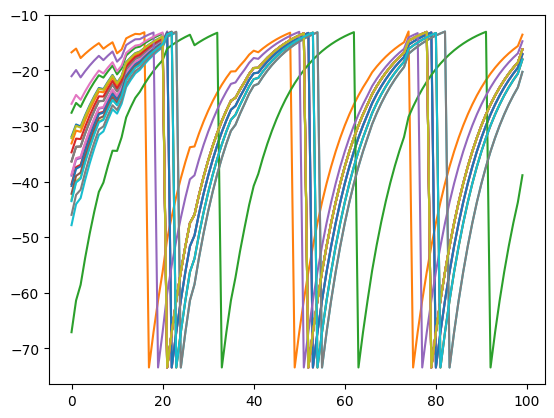

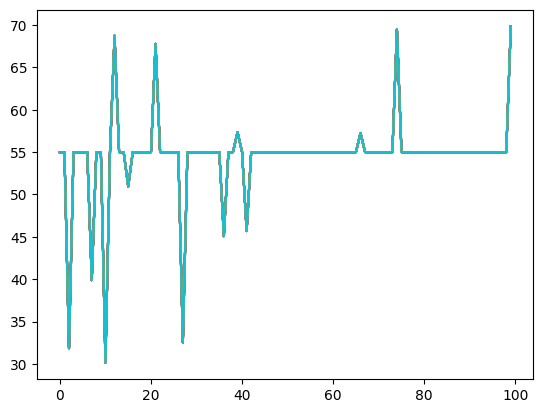

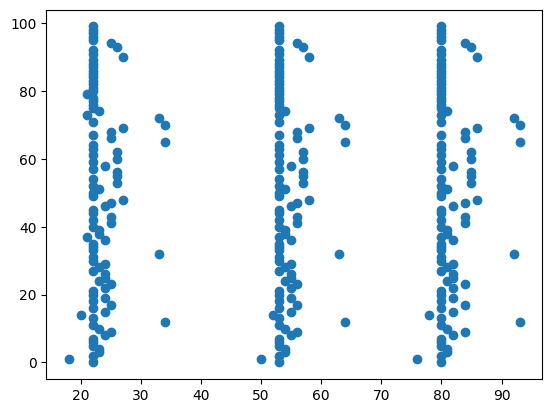

In [2150]:
net.initialize()
net.simulate_iterations(100)

plt.plot(net["v", 0][:,:20])
plt.show()
plt.plot(net["I", 0][:,:20])
plt.show()

plt.scatter(net["spike", 0][:,0], net["spike", 0][:,1])
plt.show()


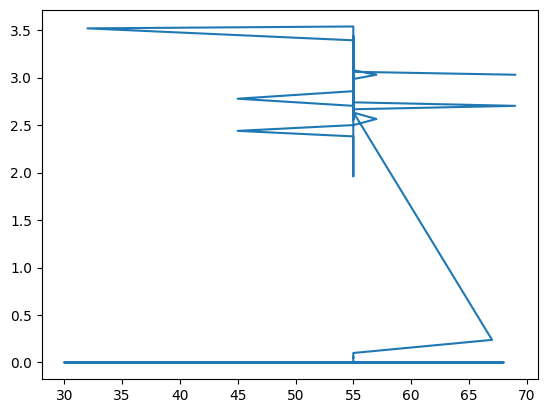

In [2151]:
spike_x = []
spike_y = []
num_spike = 0
dt = 1
iteration = 100
for i in range (1,iteration):
    num_spike +=  int(sum(net["spike"][0] == i*dt)[0])
    spike_x.append(int(net["I",0][i,0]))
    spike_y.append(num_spike/(i*dt))

plt.plot(spike_x, spike_y)
plt.show()

## ELIF Model

In [2207]:
class ELIF(Behavior):
    def initialize(self, ng):
        k = self.parameter("v_init" , default = "normal(0.3,0.05)")
        self.tau  = self.parameter("tau")
        self.u_rest = self.parameter("u_rest")
        self.u_reset = self.parameter("u_reset")
        self.theta_rh = self.parameter("theta_rh")
        self.threshold = self.parameter("threshold")
        self.R = self.parameter("R")
        self.sharpness = self.parameter("sharpness")

        ng.v = ng.vector(mode = k)
        ng.spike = ng.v >= self.threshold 
        ng.v[ng.spike] = self.u_reset

    def forward(self, ng):
        #dynamic
        leakage = -(ng.v-self.u_rest)
        currents = self.R *ng.I 
        Expon = self.sharpness*torch.exp((ng.v-self.theta_rh)/self.sharpness)
        ng.v += (leakage + currents + Expon) / self.tau * ng.network.dt

        #firing 
        ng.spike = ng.v >= self.threshold

        #reset 
        ng.v[ng.spike] = self.u_reset


In [ ]:
class ELIF(Behavior):
    def initialize(self, ng):
        k = self.parameter("v_init" , default = "normal(0.3,0.05)")
        self.tau  = self.parameter("tau")
        self.u_rest = self.parameter("u_rest")
        self.u_reset = self.parameter("u_reset")
        self.theta_rh = self.parameter("theta_rh")
        self.threshold = self.parameter("threshold")
        self.R = self.parameter("R")
        self.sharpness = self.parameter("sharpness")
        self.rp = self.parameter("refractory_period")

        ng.v = ng.vector(mode = k)
        ng.rp = ng.vector(mode = 0)
        ng.spike = ng.v >= self.threshold 
        ng.rp[ng.spike] = self.rp
        ng.v[ng.spike] = self.u_reset

    def forward(self, ng):
        #dynamic
        leakage = -(ng.v-self.u_rest)
        currents = self.R *ng.I 
        Expon = self.sharpness*torch.exp((ng.v-self.theta_rh)/self.sharpness)
        ng.v += (leakage + currents + Expon) / self.tau * ng.network.dt
        ng.v[ng.rp > 0] = self.u_reset
        ng.rp -= 1
        #firing 
        ng.spike = ng.v >= self.threshold
        ng.rp[ng.spike] = self.rp
        #reset 
        ng.v[ng.spike] = self.u_reset


### With constant Function:

In [2208]:
net = Network(behavior={1: TR()}, dtype = torch.float64)

In [2209]:
ng1 = NeuronGroup(
    100,
    net = net, 
    behavior={
        2: SetCurrent(value=45),
        5:ELIF(
            sharpness=10,
            tau = 10,
            u_rest=-65,
            u_reset=-73.42,
            threshold=-13,
            R=1,
            refractory_period = 3,
            theta_rh = -25,
            v_init="normal(-40, 10)",),
            9: Recorder(variables=["v", "I"], tag="ng1_rec, ng1_recorder"),
            10: EventRecorder("spike", tag="ng1_evrec"),
    },
    tag="NG1",
)

In [2155]:
SynapseGroup(net=net, src=ng1, dst=ng1, behavior={
                 3: SynapseFunction(),
             })

SynapseGroup['SynapseGroup_1', 'SynapseGroup', 'syn', 'NG1 => NG1'](S100xD100){3:SynapseFunction(),}

Network['Network_1', 'Network'](Neurons: tensor(100)|1 groups, Synapses: tensor(0.)|0 groups){1:TR()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](100){2:SetCurrent(value=45,)5:ELIF(sharpness=10,tau=10,u_rest=-65,u_reset=-73.42,threshold=-13,R=1,refractory_period=3,theta_rh=-25,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_evrec,arg_0=spike,)}
100xBatch: 1/1 (100%) 199.212ms


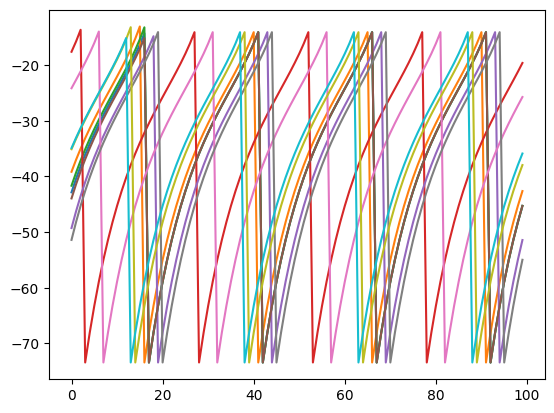

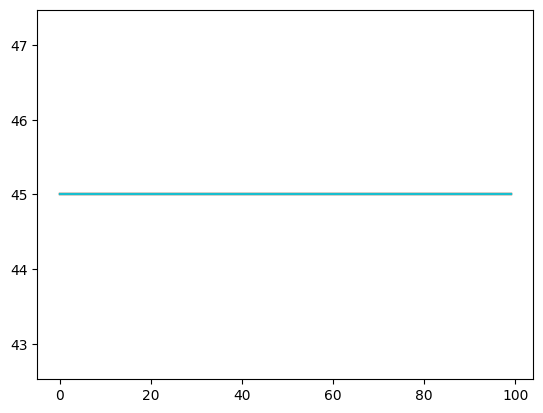

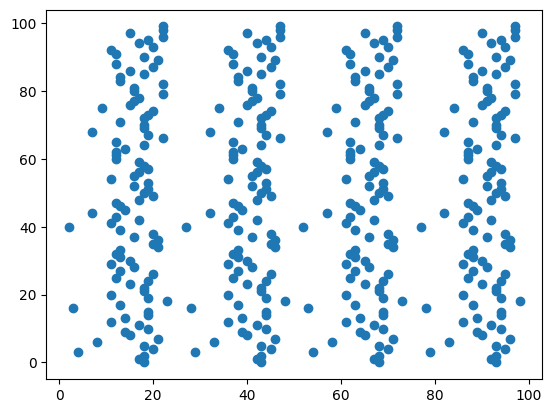

In [2210]:
net.initialize()
net.simulate_iterations(100)

plt.plot(net["v", 0][:,:10])
plt.show()
plt.plot(net["I", 0][:,:10])
plt.show()

plt.scatter(net["spike", 0][:,0], net["spike", 0][:,1])
plt.show()

### With Step Function

In [2157]:
net = Network(behavior={1: TR()}, dtype = torch.float64)

In [2158]:
ng1 = NeuronGroup(
    100,
    net = net, 
    behavior={
        2: SetCurrent(value=45),
        3: StepFunction(value=20, t0=40),
        5:ELIF(
            sharpness=10,
            tau = 10,
            u_rest=-65,
            u_reset=-73.42,
            threshold=-13,
            R=1,
            theta_rh = -25,
            v_init="normal(-40, 10)",),
            9: Recorder(variables=["v", "I"], tag="ng1_rec, ng1_recorder"),
            10: EventRecorder("spike", tag="ng1_evrec"),
    },
    tag="NG1",
)

Network['Network_1', 'Network'](Neurons: tensor(100)|1 groups, Synapses: tensor(0.)|0 groups){1:TR()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](100){2:SetCurrent(value=45,)3:StepFunction(value=20,t0=40,)5:ELIF(sharpness=10,tau=10,u_rest=-65,u_reset=-73.42,threshold=-13,R=1,theta_rh=-25,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_evrec,arg_0=spike,)}


100xBatch: 1/1 (100%) 232.064ms


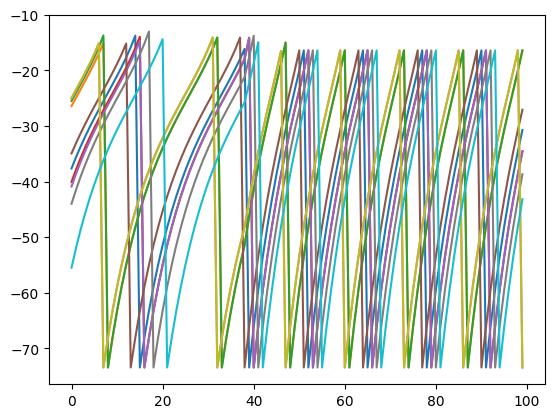

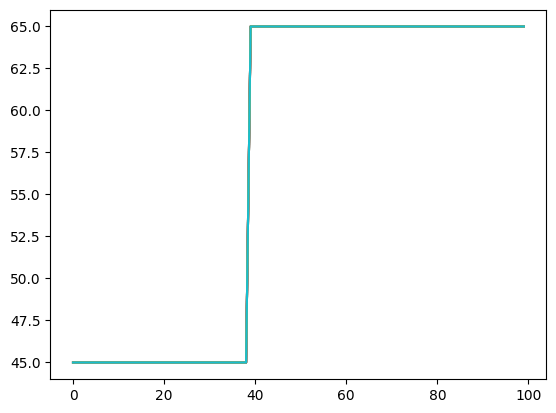

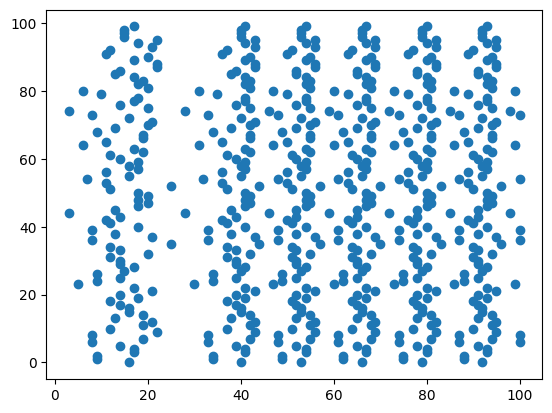

In [2159]:
net.initialize()
net.simulate_iterations(100)

plt.plot(net["v", 0][:,:10])
plt.show()
plt.plot(net["I", 0][:,:10])
plt.show()

plt.scatter(net["spike", 0][:,0], net["spike", 0][:,1])
plt.show()

### With Sin Function

In [2160]:
net = Network(behavior={1: TR()}, dtype = torch.float64)

In [2161]:
ng1 = NeuronGroup(
    100,
    net = net, 
    behavior={
        2: SetCurrent(value=45),
        3: SinFunction(value=70, a=5),
        5:ELIF(
            sharpness=10,
            tau = 10,
            u_rest=-65,
            u_reset=-73.42,
            threshold=-13,
            R=1,
            theta_rh = -25,
            v_init="normal(-40, 10)",),
            9: Recorder(variables=["v", "I"], tag="ng1_rec, ng1_recorder"),
            10: EventRecorder("spike", tag="ng1_evrec"),
    },
    tag="NG1",
)

Network['Network_1', 'Network'](Neurons: tensor(100)|1 groups, Synapses: tensor(0.)|0 groups){1:TR()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](100){2:SetCurrent(value=45,)3:SinFunction(value=70,a=5,)5:ELIF(sharpness=10,tau=10,u_rest=-65,u_reset=-73.42,threshold=-13,R=1,theta_rh=-25,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_evrec,arg_0=spike,)}


100xBatch: 1/1 (100%) 1154.909ms


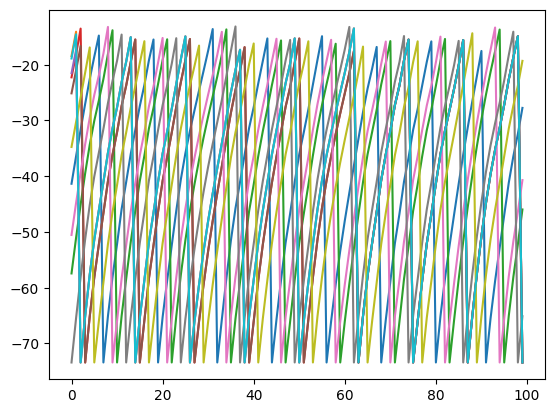

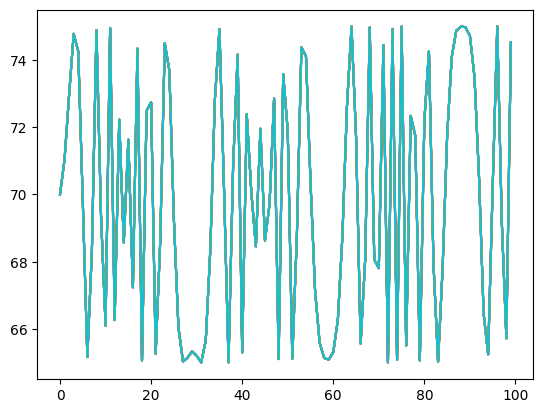

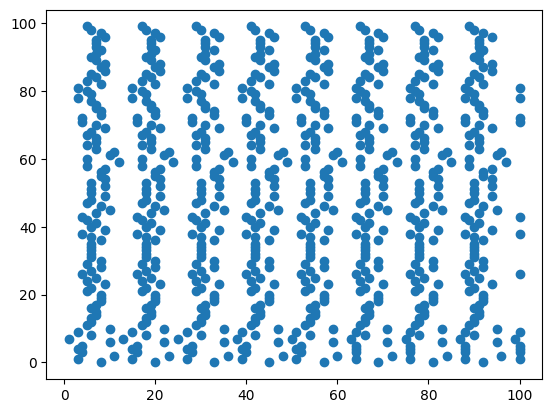

In [2162]:
net.initialize()
net.simulate_iterations(100)

plt.plot(net["v", 0][:,:10])
plt.show()
plt.plot(net["I", 0][:,:10])
plt.show()

plt.scatter(net["spike", 0][:,0], net["spike", 0][:,1])
plt.show()

### With noisy Function

In [2163]:
net = Network(behavior={1: TR()}, dtype = torch.float64)

In [2164]:
ng1 = NeuronGroup(
    100,
    net = net, 
    behavior={
        2: SetCurrent(value=45),
        3: NoiseFunction(value=55,limit = 25, rate = 0.3),
        5:ELIF(
            sharpness=10,
            tau = 10,
            u_rest=-65,
            u_reset=-73.42,
            threshold=-13,
            R=1,
            theta_rh = -25,
            v_init="normal(-40, 10)",),
            9: Recorder(variables=["v", "I"], tag="ng1_rec, ng1_recorder"),
            10: EventRecorder("spike", tag="ng1_evrec"),
    },
    tag="NG1",
)

Network['Network_1', 'Network'](Neurons: tensor(100)|1 groups, Synapses: tensor(0.)|0 groups){1:TR()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](100){2:SetCurrent(value=45,)3:NoiseFunction(value=55,limit=25,rate=0.3,)5:ELIF(sharpness=10,tau=10,u_rest=-65,u_reset=-73.42,threshold=-13,R=1,theta_rh=-25,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_evrec,arg_0=spike,)}


100xBatch: 1/1 (100%) 830.841ms


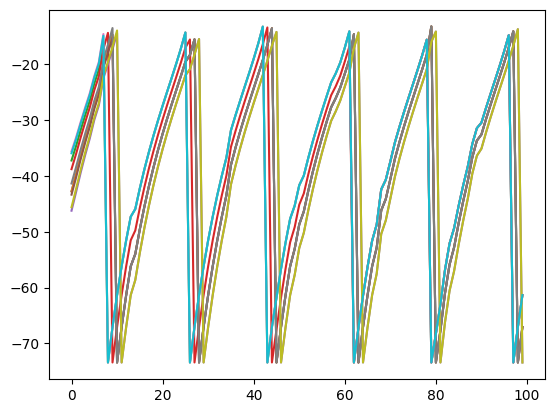

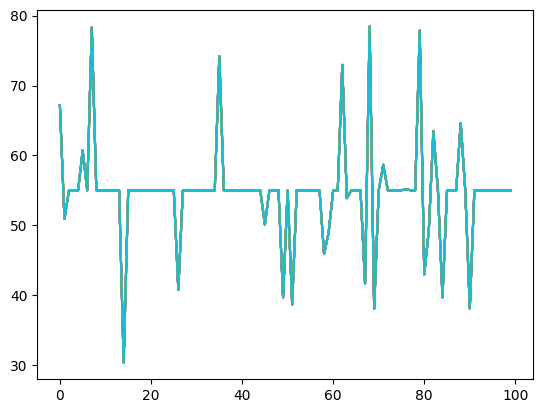

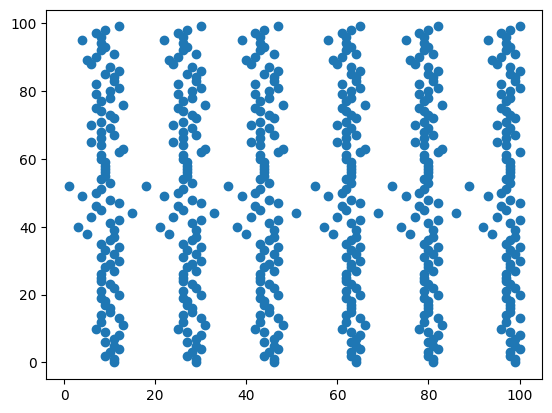

In [2165]:
net.initialize()
net.simulate_iterations(100)

plt.plot(net["v", 0][:,:10])
plt.show()
plt.plot(net["I", 0][:,:10])
plt.show()

plt.scatter(net["spike", 0][:,0], net["spike", 0][:,1])
plt.show()

## AELIF Model

In [2223]:
class AELIF(Behavior):
    def initialize(self, ng):
        k = self.parameter("v_init" , default = "normal(0.3,0.05)")
        self.tauw  = self.parameter("tauw")
        self.taum = self.parameter("taum")
        self.u_rest = self.parameter("u_rest")
        self.u_reset = self.parameter("u_reset")
        self.theta_rh = self.parameter("theta_rh")
        self.threshold = self.parameter("threshold")
        self.R = self.parameter("R")
        self.sharpness = self.parameter("sharpness")
        w = self.parameter("w")
        self.a = self.parameter("a")
        self.b = self.parameter("b")


        ng.w = ng.vector(mode=w)
        ng.v = ng.vector(mode = k)
        ng.spike = ng.v >= self.threshold 
        ng.v[ng.spike] = self.u_reset

    def forward(self, ng):
        #dynamic
        leakage=-(ng.v-self.u_rest)
        currents=self.R*ng.I 
        adaptition=self.R*ng.w
        Expon=self.sharpness*torch.exp((ng.v-self.theta_rh)/self.sharpness)
        
        ng.v+=(leakage+currents+Expon-adaptition)/self.taum*ng.network.dt


        #firing 
        ng.spike = ng.v >= self.threshold
        ng.w += (self.a*(leakage)-ng.w+self.b*self.tauw*sum(bool(x) for x in ng.spike)) / self.tauw *ng.network.dt

        #reset 
        ng.v[ng.spike] = self.u_reset


In [2214]:
class AELIF(Behavior):
    def initialize(self, ng):
        k = self.parameter("v_init" , default = "normal(0.3,0.05)")
        self.tauw  = self.parameter("tauw")
        self.taum = self.parameter("taum")
        self.u_rest = self.parameter("u_rest")
        self.u_reset = self.parameter("u_reset")
        self.theta_rh = self.parameter("theta_rh")
        self.threshold = self.parameter("threshold")
        self.R = self.parameter("R")
        self.sharpness = self.parameter("sharpness")
        w = self.parameter("w")
        self.a = self.parameter("a")
        self.b = self.parameter("b")
        self.rp = self.parameter("refractory_period")

        ng.w = ng.vector(mode=w)
        ng.v = ng.vector(mode = k)
        ng.rp = ng.vector(mode = 0)
        ng.spike = ng.v >= self.threshold 
        ng.rp[ng.spike] = self.rp
        ng.v[ng.spike] = self.u_reset

    def forward(self, ng):
        #dynamic
        leakage=-(ng.v-self.u_rest)
        currents=self.R*ng.I 
        adaptition=self.R*ng.w
        Expon=self.sharpness*torch.exp((ng.v-self.theta_rh)/self.sharpness)
        
        ng.v+=(leakage+currents+Expon-adaptition)/self.taum*ng.network.dt
        ng.v[ng.rp > 0] = self.u_reset
        ng.rp -= 1

        #firing 
        ng.spike = ng.v >= self.threshold
        ng.w += (self.a*(leakage)-ng.w+self.b*self.tauw*sum(bool(x) for x in ng.spike)) / self.tauw *ng.network.dt
        ng.rp[ng.spike] = self.rp
        #reset 
        ng.v[ng.spike] = self.u_reset


### With constant Function:

In [2224]:
net = Network(behavior={1: TR()}, dtype = torch.float64)

In [2226]:
ng1 = NeuronGroup(
    100,
    net = net, 
    behavior={
        2: SetCurrent(value=100),
        #3: StepFunction(value=20, t0=20),
        # 4: InputSynapse(),
        5: AELIF(
            sharpness=10,
            taum = 10,
            tauw = 15,
            a = 1.3,
            w =20,
            b = 1,
            u_rest=-65,
            u_reset=-73.42,
            threshold=-13,
            R=1,
            refractory_period = 3,
            theta_rh = -25,
            v_init="normal(-40, 10)",),
            9: Recorder(variables=["v", "I"], tag="ng1_rec, ng1_recorder"),
            10: EventRecorder("spike", tag="ng1_evrec"),
    },
    tag="NG1",
)

Network['Network_1', 'Network'](Neurons: tensor(200)|2 groups, Synapses: tensor(0.)|0 groups){1:TR()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](100){2:SetCurrent(value=100,)5:AELIF(sharpness=10,taum=10,tauw=15,a=1.3,w=20,b=1,u_rest=-65,u_reset=-73.42,threshold=-13,R=1,refractory_period=3,theta_rh=-25,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_evrec,arg_0=spike,)}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](100){2:SetCurrent(value=100,)5:AELIF(sharpness=10,taum=10,tauw=15,a=1.3,w=20,b=1,u_rest=-65,u_reset=-73.42,threshold=-13,R=1,refractory_period=3,theta_rh=-25,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_evrec,arg_0=spike,)}
100xBatch: 1/1 (100%) 409.

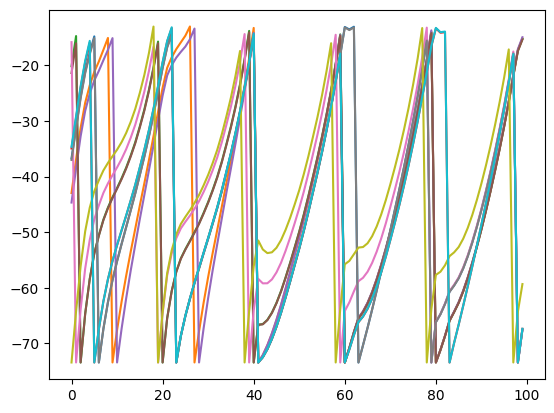

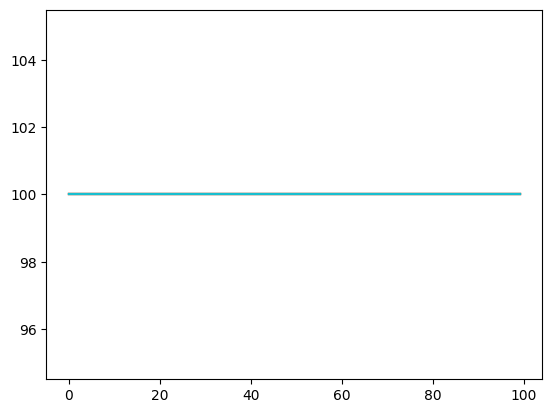

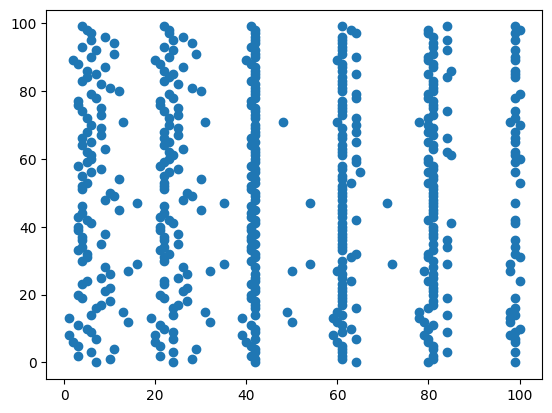

In [2227]:
net.initialize()
net.simulate_iterations(100)

plt.plot(net["v", 0][:,:10])
plt.show()
plt.plot(net["I", 0][:,:10])
plt.show()

plt.scatter(net["spike", 0][:,0], net["spike", 0][:,1])
plt.show()


### With Step Function:

In [2170]:
net = Network(behavior={1: TR()}, dtype = torch.float64)

In [2171]:
ng1 = NeuronGroup(
    100,
    net = net, 
    behavior={
        2: SetCurrent(value=100),
        3: StepFunction(value=20, t0=20),
        # 4: InputSynapse(),
        5: AELIF(
            sharpness=10,
            taum = 10,
            tauw = 15,
            a = 1.3,
            w =20,
            b = 1,
            u_rest=-65,
            u_reset=-73.42,
            threshold=-13,
            R=1,
            theta_rh = -25,
            v_init="normal(-40, 10)",),
            9: Recorder(variables=["v", "I"], tag="ng1_rec, ng1_recorder"),
            10: EventRecorder("spike", tag="ng1_evrec"),
    },
    tag="NG1",
)

Network['Network_1', 'Network'](Neurons: tensor(100)|1 groups, Synapses: tensor(0.)|0 groups){1:TR()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](100){2:SetCurrent(value=100,)3:StepFunction(value=20,t0=20,)5:AELIF(sharpness=10,taum=10,tauw=15,a=1.3,w=20,b=1,u_rest=-65,u_reset=-73.42,threshold=-13,R=1,theta_rh=-25,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_evrec,arg_0=spike,)}


100xBatch: 1/1 (100%) 219.981ms


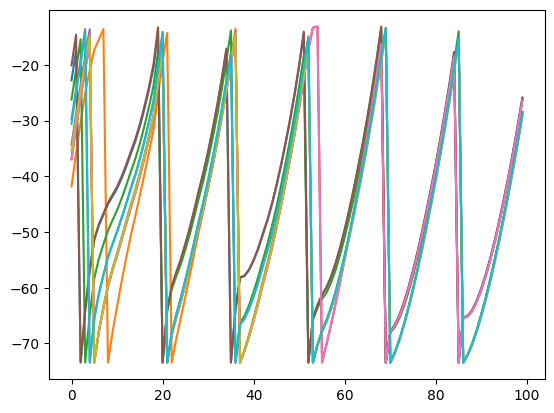

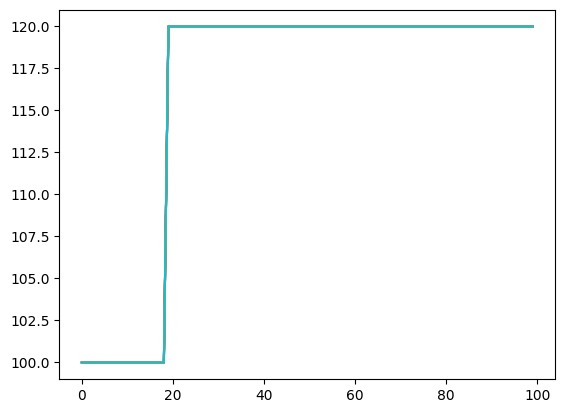

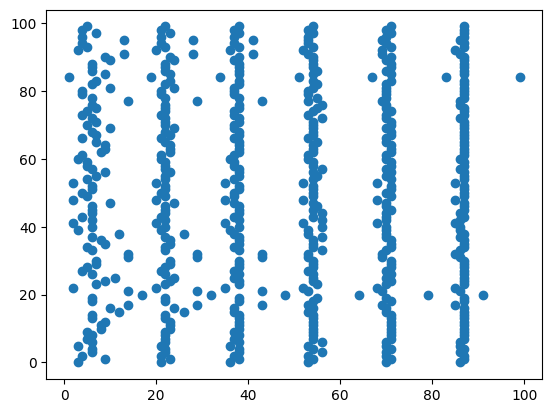

In [2172]:
net.initialize()
net.simulate_iterations(100)

plt.plot(net["v", 0][:,:10])
plt.show()
plt.plot(net["I", 0][:,:10])
plt.show()

plt.scatter(net["spike", 0][:,0], net["spike", 0][:,1])
plt.show()


### With Sin Function:

In [2173]:
net = Network(behavior={1: TR()}, dtype = torch.float64)

In [2174]:
ng1 = NeuronGroup(
    100,
    net = net, 
    behavior={
        2: SetCurrent(value=100),
        3: SinFunction(value=70, a=5),
        # 4: InputSynapse(),
        5: AELIF(
            sharpness=10,
            taum = 10,
            tauw = 15,
            a = 1.3,
            w =20,
            b = 1,
            u_rest=-65,
            u_reset=-73.42,
            threshold=-13,
            R=1,
            theta_rh = -25,
            v_init="normal(-40, 10)",),
            9: Recorder(variables=["v", "I"], tag="ng1_rec, ng1_recorder"),
            10: EventRecorder("spike", tag="ng1_evrec"),
    },
    tag="NG1",
)

Network['Network_1', 'Network'](Neurons: tensor(100)|1 groups, Synapses: tensor(0.)|0 groups){1:TR()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](100){2:SetCurrent(value=100,)3:SinFunction(value=70,a=5,)5:AELIF(sharpness=10,taum=10,tauw=15,a=1.3,w=20,b=1,u_rest=-65,u_reset=-73.42,threshold=-13,R=1,theta_rh=-25,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_evrec,arg_0=spike,)}
100xBatch: 1/1 (100%) 684.495ms


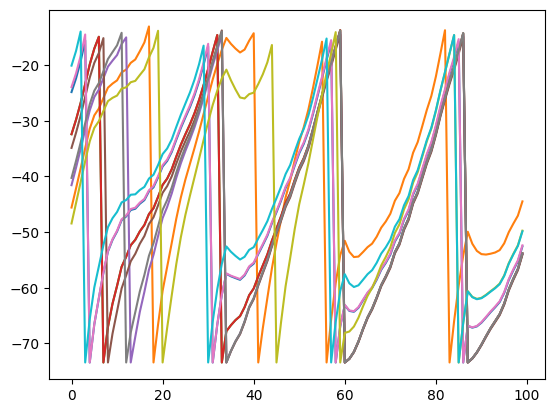

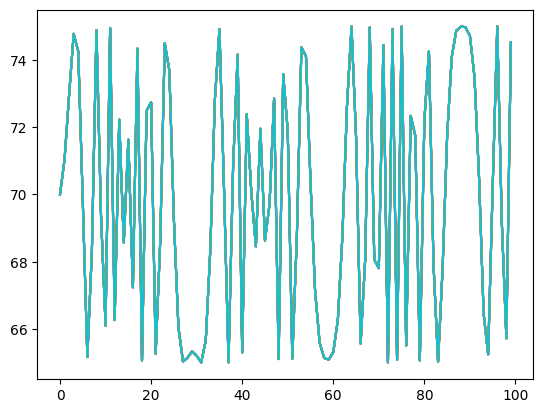

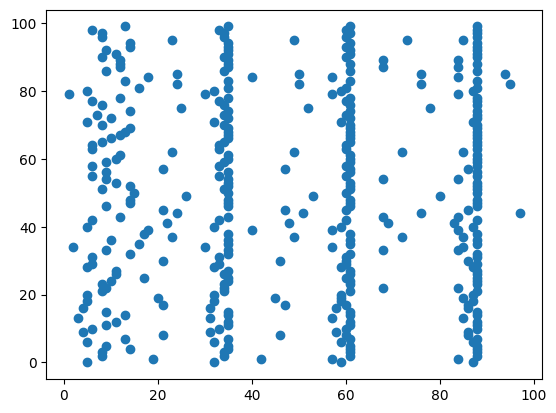

In [2175]:
net.initialize()
net.simulate_iterations(100)

plt.plot(net["v", 0][:,:10])
plt.show()
plt.plot(net["I", 0][:,:10])
plt.show()

plt.scatter(net["spike", 0][:,0], net["spike", 0][:,1])
plt.show()


### With Noisy Function:

In [2176]:
net = Network(behavior={1: TR()}, dtype = torch.float64)

In [2177]:
ng1 = NeuronGroup(
    100,
    net = net, 
    behavior={
        2: SetCurrent(value=100),
        3: NoiseFunction(value=55,limit = 25, rate = 0.3),
        # 4: InputSynapse(),
        5: AELIF(
            sharpness=10,
            taum = 10,
            tauw = 15,
            a = 1.3,
            w =20,
            b = 1,
            u_rest=-65,
            u_reset=-73.42,
            threshold=-13,
            R=1,
            theta_rh = -25,
            v_init="normal(-40, 10)",),
            9: Recorder(variables=["v", "I"], tag="ng1_rec, ng1_recorder"),
            10: EventRecorder("spike", tag="ng1_evrec"),
    },
    tag="NG1",
)

Network['Network_1', 'Network'](Neurons: tensor(100)|1 groups, Synapses: tensor(0.)|0 groups){1:TR()}
NeuronGroup['NG1', 'NeuronGroup', 'ng'](100){2:SetCurrent(value=100,)3:NoiseFunction(value=55,limit=25,rate=0.3,)5:AELIF(sharpness=10,taum=10,tauw=15,a=1.3,w=20,b=1,u_rest=-65,u_reset=-73.42,threshold=-13,R=1,theta_rh=-25,v_init=normal(-40, 10),)9:Recorder(variables=['v', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=ng1_rec, ng1_recorder,)10:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=ng1_evrec,arg_0=spike,)}


100xBatch: 1/1 (100%) 803.626ms


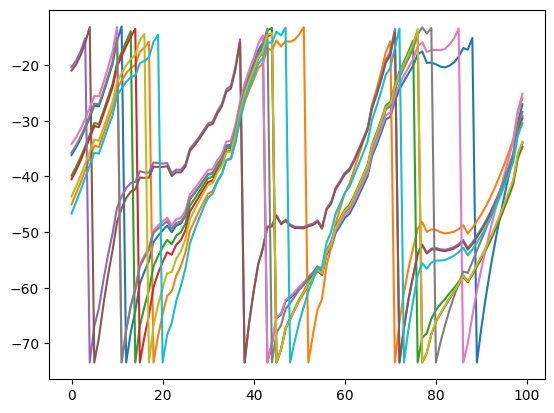

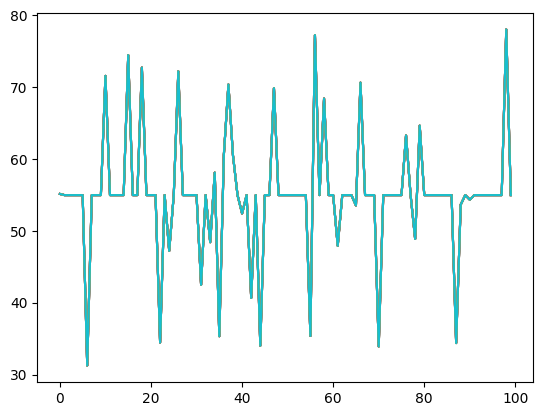

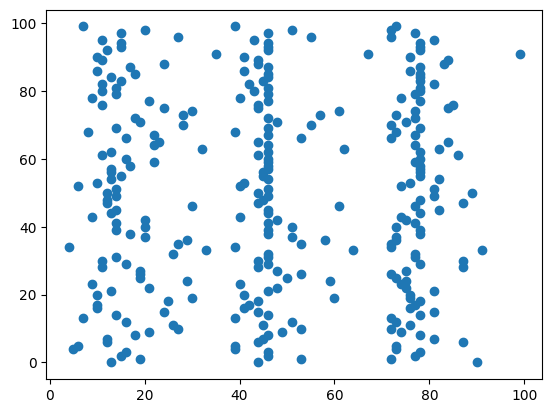

In [2178]:
net.initialize()
net.simulate_iterations(100)

plt.plot(net["v", 0][:,:10])
plt.show()
plt.plot(net["I", 0][:,:10])
plt.show()

plt.scatter(net["spike", 0][:,0], net["spike", 0][:,1])
plt.show()
